## Initialization

In [1]:
import pandas as pd
import numpy as np
from PIL import Image
import os
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.resnet import ResNet50

## Load Data

The dataset is stored in the `/datasets/faces/` folder, there you can find
- The `final_files` folder with 7.6k photos
- The `labels.csv` file with labels, with two columns: `file_name` and `real_age`

Given the fact that the number of image files is rather high, it is advisable to avoid reading them all at once, which would greatly consume computational resources. We recommend you build a generator with the ImageDataGenerator generator. This method was explained in Chapter 3, Lesson 7 of this course.

The label file can be loaded as an usual CSV file.

In [2]:
# create variables for paths
label_csv = '/datasets/faces/labels.csv'
photo_dir = '/datasets/faces/final_files/'

# read csv
labels = pd.read_csv(label_csv)

In [3]:
# view data
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [4]:
# see basic info
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


The labels csv contains 7591 rows and two columns: `file_name`, which corresponds to an image in the photo directory, and `real_age` which is the actual age of the person depicted in the file. There are no null values, so next I will go into EDA.

## EDA

I will first conduct preliminary EDA on the dataset. I'm interested in seeing the distributions of ages and will look at a few photos from the dataset as well.

In [5]:
# view summary statistics
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


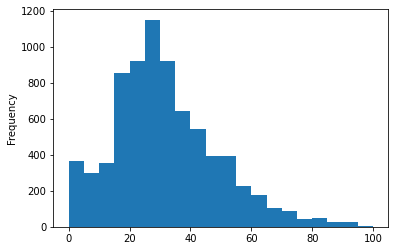

In [6]:
# view the ages
labels['real_age'].plot(kind='hist', bins=range(0, 105, 5));

From the sumamry statistics and the histogram, we can see that ages range between 1-100, but 31 is the mean age represented in the photos. Most ages are clustered around 20-40 years, and there's a significant right tail. Our model may struggle to tell the ages of senior individuals. 

Next, I will observe a few photos from the dataset.

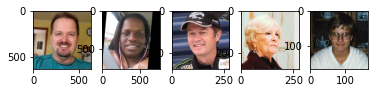

In [21]:
# collect random photo names
samples = labels.sample(n = 5, random_state=12345)['file_name'].to_list()

# show photos
for i, sample in enumerate(samples):
    path = os.path.join(photo_dir, sample)
    image = Image.open(path)
    array = np.array(image)
    
    plt.figure
    plt.subplot(1, 5, i+1)
    plt.imshow(image)

Of the five images shown above, there are some colored selfies and some other photos. The photos are concentrated around the face and have varying expressions. The second photo is rotated a little.

### Findings

Overall, EDA has revealed the average age of people pictures (20-40) and that the colored photos are a focus on the face.

## Modelling

Define the necessary functions to train your model on the GPU platform and build a single script containing all of them along with the initialization section.

To make this task easier, you can define them in this notebook and run a ready code in the next section to automatically compose the script.

The definitions below will be checked by project reviewers as well, so that they can understand how you built the model.

In [23]:
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

In [52]:
def load_train(path):
    
    """
    It loads the train part of dataset from path
    """
    
    label_csv = '/datasets/faces/labels.csv'
    photo_dir = '/datasets/faces/final_files/'

    labels = pd.read_csv(label_csv)
    
    train_datagen = ImageDataGenerator(validation_split=0.25, rescale=1/255, 
                                    horizontal_flip=True, vertical_flip=True)
    
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=photo_dir,
        x_col='file_name',
        y_col='real_age',
        subset='training',
        target_size=(150, 150),
        batch_size=16,
        class_mode='raw',
        seed=12345
    )

    return train_gen_flow

In [55]:
def load_test(path):
    
    """
    It loads the validation/test part of dataset from path
    """
    
    label_csv = '/datasets/faces/labels.csv'
    photo_dir = '/datasets/faces/final_files/'
    
    labels = pd.read_csv(label_csv)

    test_datagen = ImageDataGenerator(validation_split=0.25, rescale=1/255, 
                                    horizontal_flip=True, vertical_flip=True)
    
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=photo_dir,
        x_col='file_name',
        y_col='real_age',
        subset='validation',
        target_size=(150, 150),
        batch_size=16,
        class_mode='raw',
        seed=12345
    )

    return test_gen_flow

In [46]:
def create_model(input_shape):
    
    """
    It defines the model
    """
    
    backbone = ResNet50(input_shape=input_shape, weights='imagenet', include_top=False)
    
    model=Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1,activation='relu'))
    optimizer=Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss='mae', metrics=['mae'])

    return model

In [47]:
def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    """
    Trains the model given the parameters
    """
    
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    
    model.fit(train_data,
          validation_data=test_data,
          epochs=epochs,
          batch_size=batch_size,
          steps_per_epoch=steps_per_epoch,
          validation_steps=validation_steps,
          verbose=2) 

    return model

### Prepare the Script to Run on the GPU Platform

Given you've defined the necessary functions you can compose a script for the GPU platform, download it via the "File|Open..." menu, and to upload it later for running on the GPU platform.

N.B.: The script should include the initialization section as well. An example of this is shown below.

In [56]:
# prepare a script to run on the GPU platform

init_str = """
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
"""

import inspect

with open('run_model_on_gpu.py', 'w') as f:
    
    f.write(init_str)
    f.write('\n\n')
        
    for fn_name in [load_train, load_test, create_model, train_model]:
        
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')

### Output

Place the output from the GPU platform as an Markdown cell here.

Train for 356 steps, validate for 119 steps

Epoch 1/20
356/356 - 49s - loss: 11.7948 - mae: 11.7957 - val_loss: 20.4237 - val_mae: 20.4190

Epoch 2/20
356/356 - 38s - loss: 8.6644 - mae: 8.6643 - val_loss: 11.1326 - val_mae: 11.1242

Epoch 3/20
356/356 - 38s - loss: 7.8838 - mae: 7.8837 - val_loss: 7.6987 - val_mae: 7.6973

Epoch 4/20
356/356 - 38s - loss: 7.3057 - mae: 7.3057 - val_loss: 8.2587 - val_mae: 8.2668

Epoch 5/20
356/356 - 38s - loss: 6.8468 - mae: 6.8468 - val_loss: 7.3350 - val_mae: 7.3440

Epoch 6/20
356/356 - 38s - loss: 6.6294 - mae: 6.6294 - val_loss: 7.5884 - val_mae: 7.5953

Epoch 7/20
356/356 - 38s - loss: 6.0601 - mae: 6.0602 - val_loss: 6.8599 - val_mae: 6.8651

Epoch 8/20
356/356 - 38s - loss: 5.8302 - mae: 5.8303 - val_loss: 7.3414 - val_mae: 7.3503

Epoch 9/20
356/356 - 38s - loss: 5.4516 - mae: 5.4516 - val_loss: 6.8304 - val_mae: 6.8423

Epoch 10/20
356/356 - 38s - loss: 5.1406 - mae: 5.1411 - val_loss: 6.9808 - val_mae: 6.9863

Epoch 11/20
356/356 - 38s - loss: 5.0363 - mae: 5.0366 - val_loss: 7.0015 - val_mae: 7.0047

Epoch 12/20
356/356 - 38s - loss: 4.7937 - mae: 4.7941 - val_loss: 7.8938 - val_mae: 7.8991

Epoch 13/20
356/356 - 38s - loss: 4.6156 - mae: 4.6158 - val_loss: 6.8987 - val_mae: 6.8984

Epoch 14/20
356/356 - 38s - loss: 4.4957 - mae: 4.4956 - val_loss: 6.7492 - val_mae: 6.7561

Epoch 15/20
356/356 - 38s - loss: 4.3577 - mae: 4.3575 - val_loss: 6.6150 - val_mae: 6.6244

Epoch 16/20
356/356 - 38s - loss: 4.1288 - mae: 4.1290 - val_loss: 7.0991 - val_mae: 7.1091

Epoch 17/20
356/356 - 38s - loss: 4.1554 - mae: 4.1557 - val_loss: 6.8879 - val_mae: 6.9007

Epoch 18/20
356/356 - 38s - loss: 3.8717 - mae: 3.8718 - val_loss: 6.6654 - val_mae: 6.6602

Epoch 19/20
356/356 - 38s - loss: 3.7747 - mae: 3.7745 - val_loss: 6.6380 - val_mae: 6.6476

Epoch 20/20
356/356 - 38s - loss: 3.6540 - mae: 3.6538 - val_loss: 7.4318 - val_mae: 7.4339

## Conclusions

In this project, 7.6k photos of faces were used for the training and testing of a neural network model with the ResNet50 architecture that was pretrained on ImageNet. 20 epochs were used (resulting in a MAE of 3.6538), but this is likely excessive, as 4-5 epochs still resulted in a MAE that was under 8. Having a MAE of 3.6538 indicates the mean absolute error between the model's predicted age and the actual age that we were given in the dataset.

# Checklist

- [x]  Notebook was opened
- [x]  The code is error free
- [x]  The cells with code have been arranged by order of execution
- [x]  The exploratory data analysis has been performed
- [x]  The results of the exploratory data analysis are presented in the final notebook
- [x]  The model's MAE score is not higher than 8
- [x]  The model training code has been copied to the final notebook
- [x]  The model training output has been copied to the final notebook
- [x]  The findings have been provided based on the results of the model training